# 7장. XGBoost로 외계 행성 찾기

*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.org/github/rickiepark/handson-gb/blob/main/Chapter07/Discovering_Exoplanets.ipynb"><img src="https://jupyter.org/assets/share.png" width="60" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-gb/blob/main/Chapter07/Discovering_Exoplanets.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [2]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !pip install -q --upgrade xgboost
    !wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter07/exoplanets.csv.zip

!unzip -o exoplanets.csv.zip

Archive:  exoplanets.csv.zip
  inflating: exoplanets.csv          
  inflating: __MACOSX/._exoplanets.csv  


In [3]:
# 경고 끄기
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
xgb.set_config(verbosity=0)

## 외계 행성 찾기

### 외계 행성 데이터셋

In [4]:
import pandas as pd
df = pd.read_csv('exoplanets.csv', nrows=400)

In [5]:
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [ ]:
df['LABEL'].value_counts()

1    363
2     37
Name: LABEL, dtype: int64

### 그래프 시각화

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()

X = df.iloc[:,1:]
y = df.iloc[:,0] - 1

def light_plot(index):
    y_vals = X.iloc[index]
    x_vals = np.arange(len(y_vals))
    plt.figure(figsize=(15,8))
    plt.xlabel('Number of Observations')
    plt.ylabel('Light Flux')
    plt.title('Light Plot ' + str(index), size=15)
    plt.plot(x_vals, y_vals)
    plt.show()

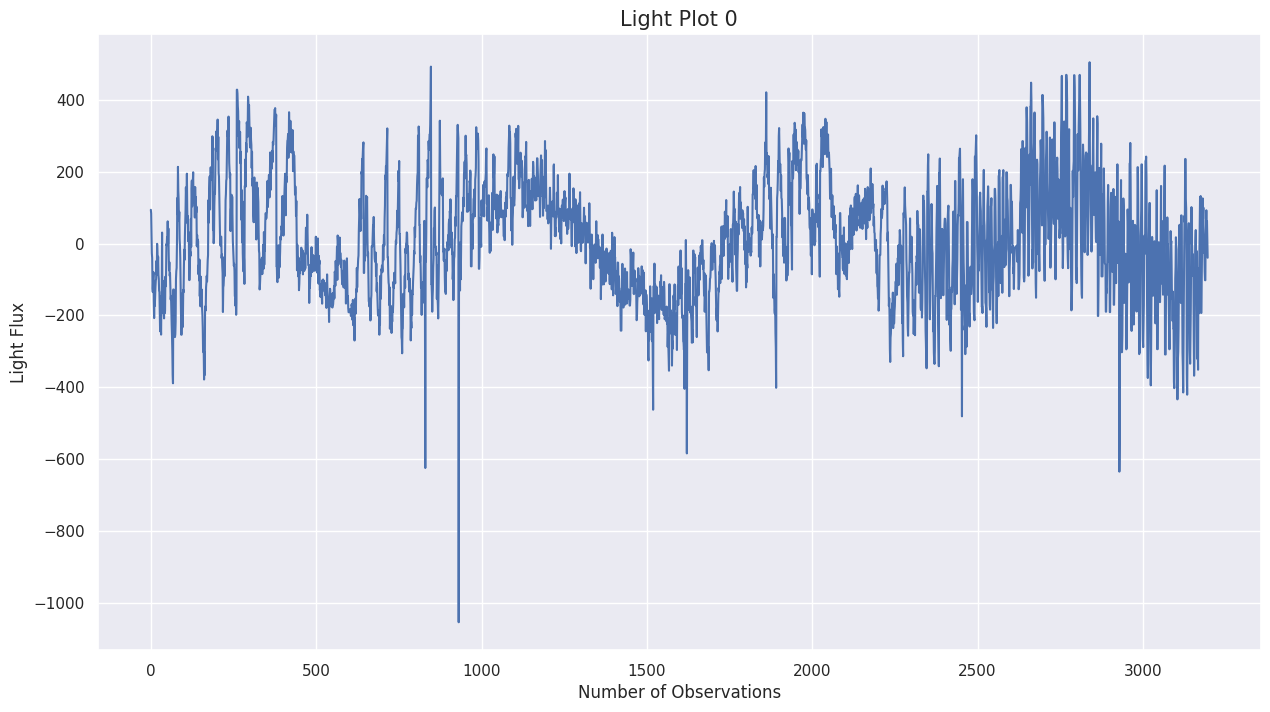

In [7]:
light_plot(0)

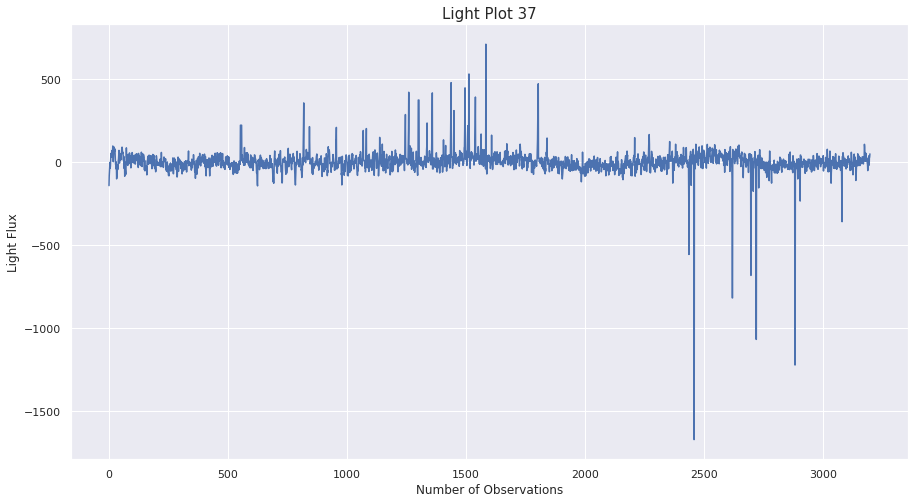

In [ ]:
light_plot(37)

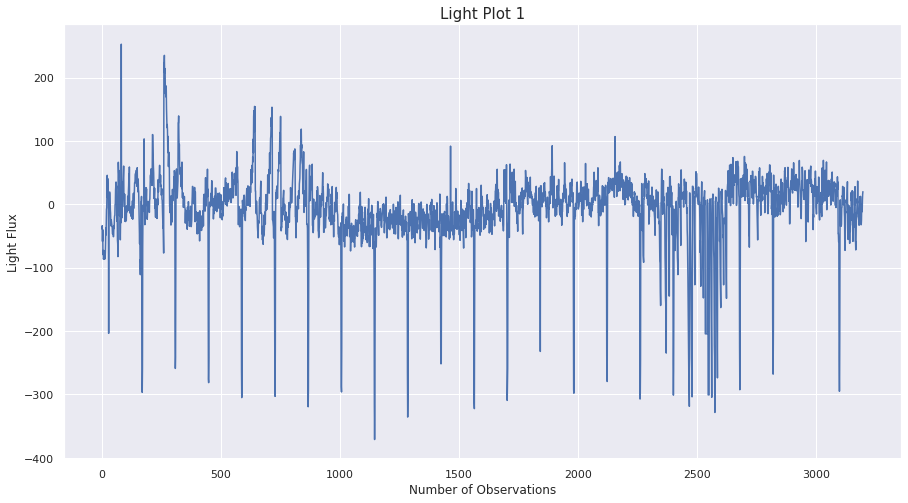

In [ ]:
light_plot(1)

# 푸리에 변환 수행

FLUX.1      -141.22
FLUX.2       -81.79
FLUX.3       -52.28
FLUX.4       -32.45
FLUX.5        -1.55
              ...  
FLUX.3193     38.66
FLUX.3194    -17.53
FLUX.3195     31.49
FLUX.3196     31.38
FLUX.3197     50.03
Name: 37, Length: 3197, dtype: float64


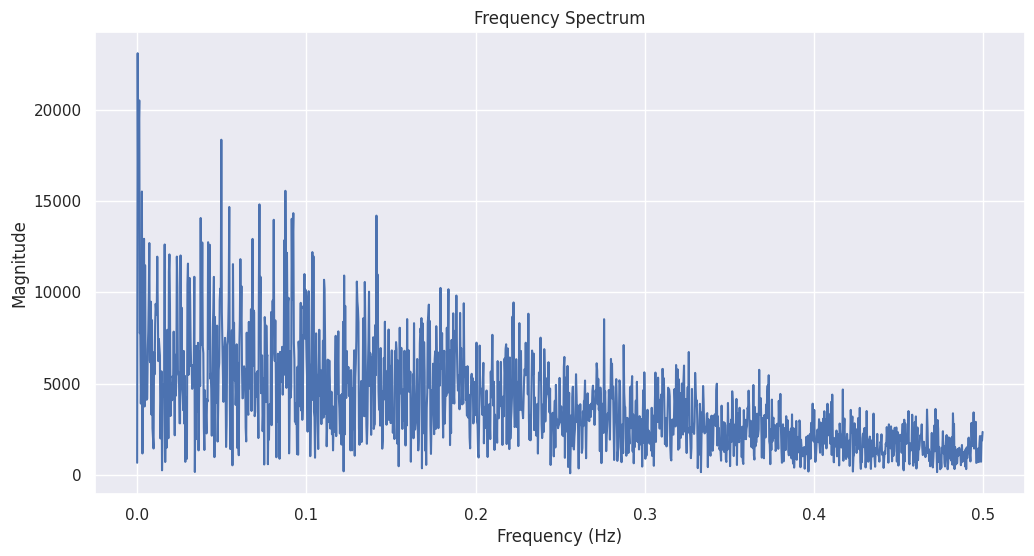

주요 주파수: 0.00031279324366593683 Hz


In [31]:
from scipy.fft import fft, fftfreq


# 샘플 하나에 대해 FFT 적용
sample_flux =  df.iloc[37,1:] # 첫 번째 샘플
print(sample_flux)
n = len(sample_flux)  # 데이터 포인트 개수
timestep = 1  # 샘플 간 간격 (필요시 수정)

# 푸리에 변환 수행
freq = fftfreq(n, d=timestep)  # 주파수 값
fft_result = fft(sample_flux.to_numpy())  # FFT 결과

# 진폭 계산
magnitude = np.abs(fft_result)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(freq[:n // 2], magnitude[:n // 2])  # 양의 주파수 성분만 시각화
plt.title("Frequency Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

# 주요 주파수 찾기
peak_freq = freq[np.argmax(magnitude[:n // 2])]  # 가장 큰 진폭의 주파수
print(f"주요 주파수: {peak_freq} Hz")

### 데이터 준비

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 3198 entries, LABEL to FLUX.3197
dtypes: float64(3197), int64(1)
memory usage: 9.8 MB


In [ ]:
# 누락된 값의 개수를 셉니다.
df.isnull().sum().sum()

0

### 초기 XGBClassifier

In [ ]:
# XGBRegressor를 임포트합니다.
from xgboost import XGBClassifier

# accuracy_score를 임포트합니다.
from sklearn.metrics import accuracy_score

# train_test_split를 임포트합니다.
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier(booster='gbtree')

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = accuracy_score(y_pred, y_test)

print('점수: ' + str(score))

점수: 0.89


## 오차 행렬 분석하기

### confusion_matrix

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[86,  2],
       [ 9,  3]])

### classification_report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94        88
           1       0.60      0.25      0.35        12

    accuracy                           0.89       100
   macro avg       0.75      0.61      0.65       100
weighted avg       0.87      0.89      0.87       100



### 다른 측정 방법

####  recall_score

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.25

## 불균형 데이터 리샘플링

### 언더샘플링

#### xgb_clf 함수

In [ ]:
def xgb_clf(model, nrows):

    df = pd.read_csv('exoplanets.csv', nrows=nrows)
    # 데이터를 X와 y로 나눕니다.
    X = df.iloc[:,1:]
    y = df.iloc[:,0] - 1

    # 데이터를 훈련 세트와 테스트 세트로 나눕니다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

    # 훈련 세트에서 모델을 훈련합니다.
    model.fit(X_train, y_train)

    # 테스트 세트에 대한 예측을 만듭니다.
    y_pred = model.predict(X_test)

    score = recall_score(y_test, y_pred)

    print(confusion_matrix(y_test, y_pred))

    print(classification_report(y_test, y_pred))

    return score

#### 언더샘플링 테스트

In [ ]:
xgb_clf(XGBClassifier(), nrows=800)

[[189   1]
 [  9   1]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       190
           1       0.50      0.10      0.17        10

    accuracy                           0.95       200
   macro avg       0.73      0.55      0.57       200
weighted avg       0.93      0.95      0.93       200



0.1

In [ ]:
xgb_clf(XGBClassifier(), nrows=200)

[[37  0]
 [ 8  5]]
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        37
           1       1.00      0.38      0.56        13

    accuracy                           0.84        50
   macro avg       0.91      0.69      0.73        50
weighted avg       0.87      0.84      0.81        50



0.38461538461538464

In [ ]:
xgb_clf(XGBClassifier(), nrows=74)

[[6 2]
 [5 6]]
              precision    recall  f1-score   support

           0       0.55      0.75      0.63         8
           1       0.75      0.55      0.63        11

    accuracy                           0.63        19
   macro avg       0.65      0.65      0.63        19
weighted avg       0.66      0.63      0.63        19



0.5454545454545454

### 오버샘플링

In [ ]:
df_train = pd.merge(y_train, X_train, left_index=True, right_index=True)

In [ ]:
newdf = pd.DataFrame(np.repeat(df_train[df_train['LABEL']==1].values,
                               9,axis=0))
newdf.columns = df_train.columns
df_train_resample = pd.concat([df_train, newdf])

df_train_resample['LABEL'].value_counts()

0.0    275
1.0    250
Name: LABEL, dtype: int64

In [ ]:
X_train_resample = df_train_resample.iloc[:,1:]
y_train_resample = df_train_resample.iloc[:,0]

In [ ]:
# XGBClassifier를 초기화합니다.
model = XGBClassifier()

# 훈련 세트로 모델을 훈련합니다.
model.fit(X_train_resample, y_train_resample)

# 테스트 세트에 대해 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[86  2]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        88
           1       0.67      0.33      0.44        12

    accuracy                           0.90       100
   macro avg       0.79      0.66      0.69       100
weighted avg       0.89      0.90      0.88       100

0.3333333333333333


## XGBClassifier 튜닝

### 가중치 조정하기

#### replace 메서드

In [ ]:
df['LABEL'] = df['LABEL'].replace(1, 0)
df['LABEL'] = df['LABEL'].replace(2, 1)

df['LABEL'].value_counts()

0    363
1     37
Name: LABEL, dtype: int64

#### scale_pos_weight

In [ ]:
# 데이터를 X와 y로 나눕니다.
X = df.iloc[:,1:]
y = df.iloc[:,0]

# 데이터를 훈련 세트와 테스트 세트로 나눕니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
model = XGBClassifier(scale_pos_weight=10)

model.fit(X_train, y_train)

# 테스트 세트에 대한 예측을 만듭니다.
y_pred = model.predict(X_test)

score = recall_score(y_test, y_pred)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

print(score)

[[86  2]
 [ 8  4]]
              precision    recall  f1-score   support

           0       0.91      0.98      0.95        88
           1       0.67      0.33      0.44        12

    accuracy                           0.90       100
   macro avg       0.79      0.66      0.69       100
weighted avg       0.89      0.90      0.88       100

0.3333333333333333


### XGBClassifier 튜닝

#### 기준 모델

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,StratifiedKFold, cross_val_score

In [ ]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=2)

model = XGBClassifier(scale_pos_weight=10)

# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, X, y, cv=kfold, scoring='recall')

# 재현율을 출력합니다.
print('재현율: ', scores)

# 재현율의 평균을 출력합니다.
print('재현율 평균: ', scores.mean())

재현율:  [0.10526316 0.27777778]
재현율 평균:  0.1915204678362573


#### grid_search

In [ ]:
def grid_search(params, random=False, X=X, y=y,
                model=XGBClassifier(scale_pos_weight=10, random_state=2)):

    xgb = model

    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_jobs=-1,
                                  random_state=2, scoring='recall')
    else:
        # 그리드 서치 객체를 초기화합니다.
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1, scoring='recall')

    # X_train와 y_train으로 훈련합니다.
    grid.fit(X, y)

    # 최상의 매개변수를 추출합니다.
    best_params = grid.best_params_

    # 최상의 매개변수를 출력합니다.
    print("최상의 매개변수:", best_params)

    # 최상의 점수를 추출합니다.
    best_score = grid.best_score_

    # 최상의 점수를 출력합니다.
    print("최상의 점수: {:.5f}".format(best_score))

In [ ]:
grid_search(params={'n_estimators':[50, 200, 400, 800]})

최상의 매개변수: {'n_estimators': 50}
최상의 점수: 0.19152


In [ ]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.2, 0.3]})

최상의 매개변수: {'learning_rate': 0.01}
최상의 점수: 0.40351


In [ ]:
grid_search(params={'max_depth':[1, 2, 4, 8]})

최상의 매개변수: {'max_depth': 2}
최상의 점수: 0.24415


In [ ]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9]})

최상의 매개변수: {'subsample': 0.3}
최상의 점수: 0.24561


In [ ]:
grid_search(params={'gamma':[0.05, 0.1, 0.5, 1]})

최상의 매개변수: {'gamma': 0.05}
최상의 점수: 0.24415


In [ ]:
grid_search(params={'learning_rate':[0.001, 0.01, 0.03],
                    'max_depth':[1, 2], 'gamma':[0.025, 0.05, 0.5]})

최상의 매개변수: {'gamma': 0.025, 'learning_rate': 0.001, 'max_depth': 2}
최상의 점수: 0.53509


In [ ]:
grid_search(params={'max_delta_step':[1, 3, 5, 7]})

최상의 매개변수: {'max_delta_step': 1}
최상의 점수: 0.24415


In [ ]:
grid_search(params={'subsample':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bylevel':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bynode':[0.3, 0.5, 0.7, 0.9, 1],
                    'colsample_bytree':[0.3, 0.5, 0.7, 0.9, 1]}, random=True)

최상의 매개변수: {'subsample': 0.3, 'colsample_bytree': 0.7, 'colsample_bynode': 0.7, 'colsample_bylevel': 1}
최상의 점수: 0.37865


#### 균형잡힌 서브셋

In [ ]:
X_short = X.iloc[:74, :]
y_short = y.iloc[:74]

In [ ]:
grid_search(params={'max_depth':[1, 2, 3],
                    'colsample_bynode':[0.5, 0.75, 1]},
            X=X_short, y=y_short,
            model=XGBClassifier(random_state=2))

최상의 매개변수: {'colsample_bynode': 0.5, 'max_depth': 1}
최상의 점수: 0.65205


#### 전체 데이터로 튜닝하기

In [ ]:
df_all = pd.read_csv('exoplanets.csv')
df_all['LABEL'] = df_all['LABEL'].replace(1, 0)
df_all['LABEL'] = df_all['LABEL'].replace(2, 1)

X_all = df_all.iloc[:,1:]
y_all = df_all.iloc[:,0]

In [ ]:
df_all['LABEL'].value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

In [ ]:
weight = int(5050/37)

In [ ]:
model = XGBClassifier(scale_pos_weight=weight)

# 교차 검증 점수를 계산합니다.
scores = cross_val_score(model, X_all, y_all, cv=kfold, scoring='recall')

# 재현율을 출력합니다.
print('재현율:', scores)

# 재현율의 평균을 출력합니다.
print('재현율 평균:', scores.mean())

재현율: [0.10526316 0.        ]
재현율 평균: 0.05263157894736842


In [ ]:
grid_search(params={'learning_rate':[0.001, 0.01]}, X=X_all, y=y_all,
            model=XGBClassifier(scale_pos_weight=weight))

최상의 매개변수: {'learning_rate': 0.001}
최상의 점수: 0.26316


In [ ]:
grid_search(params={'max_depth':[1, 2],'learning_rate':[0.001]}, X=X_all, y=y_all,
            model=XGBClassifier(scale_pos_weight=weight))

최상의 매개변수: {'learning_rate': 0.001, 'max_depth': 2}
최상의 점수: 0.53509


### 결과 통합

In [ ]:
def final_model(X, y, model):
    model.fit(X, y)
    y_pred = model.predict(X_all)
    score = recall_score(y_all, y_pred)
    print(score)
    print(confusion_matrix(y_all, y_pred))
    print(classification_report(y_all, y_pred))

#### 74개 샘플

In [ ]:
final_model(X_short, y_short,
            XGBClassifier(max_depth=2, colsample_by_node=0.5,
                          random_state=2))

1.0
[[3588 1462]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.71      0.83      5050
           1       0.02      1.00      0.05        37

    accuracy                           0.71      5087
   macro avg       0.51      0.86      0.44      5087
weighted avg       0.99      0.71      0.83      5087



#### 400개 샘플

In [ ]:
final_model(X, y,
            XGBClassifier(max_depth=2, colsample_bynode=0.5,
                          scale_pos_weight=10, random_state=2))

1.0
[[4897  153]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      5050
           1       0.19      1.00      0.33        37

    accuracy                           0.97      5087
   macro avg       0.60      0.98      0.66      5087
weighted avg       0.99      0.97      0.98      5087



#### 5,050개 샘플

In [ ]:
final_model(X_all, y_all,
            XGBClassifier(max_depth=2, colsample_bynode=0.5,
                          scale_pos_weight=weight, random_state=2))

1.0
[[5050    0]
 [   0   37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5050
           1       1.00      1.00      1.00        37

    accuracy                           1.00      5087
   macro avg       1.00      1.00      1.00      5087
weighted avg       1.00      1.00      1.00      5087

